In [19]:
import numpy as np
import matplotlib.pyplot as plt


In [20]:
def x_func(u):
    return 1.5*(np.exp(1.5*np.sin(6.2*u-0.027*37))+0.1)*np.cos(12.2*u)
def y_func(u):
    return (np.exp(np.sin(6.2*u-0.027*37))+0.1)*np.sin(12.2*u)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


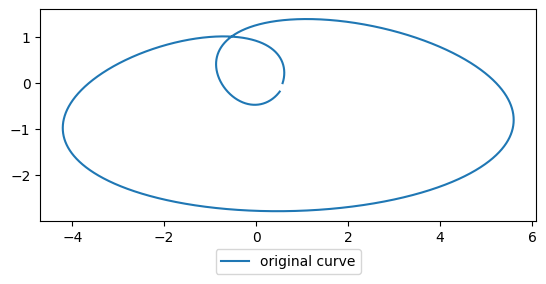

In [21]:
u = np.linspace(0,1,100000)


xs = [x_func(u_) for u_ in u]
ys = [y_func(u_) for u_ in u]

fig, ax = plt.subplots()
ax.plot(xs, ys, label="original curve")
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'plots/ori_func.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


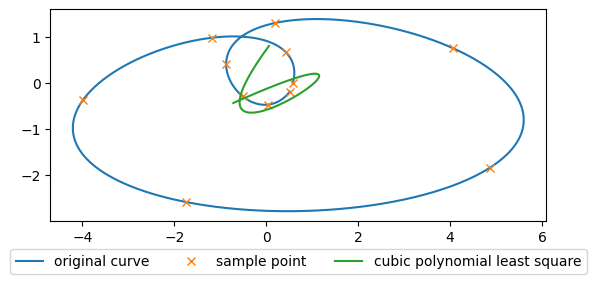

In [62]:
S = 12
degree = 3
sample_u = np.linspace(0,1,S)

A = np.zeros((S,degree+1), dtype=np.float64)
b = np.zeros((S,2), dtype=np.float64)

for i_,u_ in enumerate(sample_u):
    A[i_,:] = [ np.power(u_,d) for d in range(degree+1) ]
    b[i_,:] = [x_func(u_),y_func(u_)]

# solve: Ac = b
c = np.linalg.solve(A.T@A, A.T@b)

plot_n = 100
plot_curve = np.zeros((plot_n,2))
for i, u in enumerate(np.linspace(0,1,plot_n)):
    plot_curve[i] = np.array([np.power(u,d) for d in range(degree+1)]) @ c


fig, ax = plt.subplots()
ax.plot(xs, ys, label="original curve")
ax.plot(b[:,0], b[:,1], marker="x", label="sample point", linestyle="None")
ax.plot(plot_curve[:,0],plot_curve[:,1], label="cubic polynomial least square")
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'plots/cubic_polynomial.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


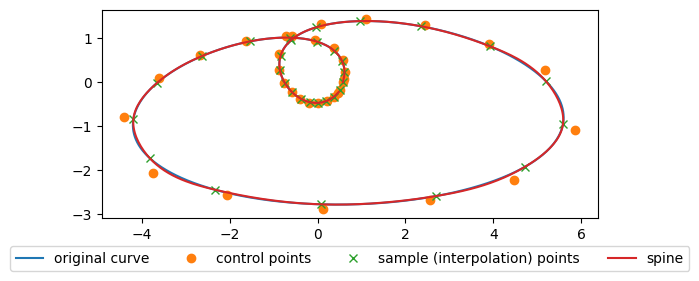

In [54]:
K = 3

S = 32
degree = 3
sample_u = np.linspace(0,1,S)

data_points = np.zeros((S,2), dtype=np.float64)

for i_,u_ in enumerate(sample_u):
    data_points[i_,:] = [x_func(u_),y_func(u_)]

total_dist = 0
for i in range(len(data_points)-1):
    total_dist += np.linalg.norm(data_points[i+1] - data_points[i])

t = np.zeros((len(data_points)),dtype=np.float64)

acc_dist = 0
for i in range(len(data_points)-1):
    acc_dist += np.linalg.norm(data_points[i+1] - data_points[i])
    t[i+1] += acc_dist / total_dist

# repeat k to tail and head for intoperate fist and last point, to produce knots
knots = np.concatenate([np.zeros(K), t, np.ones(K)],axis=0)

eps = np.finfo(np.float64).eps

for k_ in range(K+1):
    knots[k_] = (k_+1)*eps
    knots[-(k_+1)] = 1.0 - (k_+1)*eps

from sympy import Piecewise, symbols, IndexedBase, Idx, Matrix, Eq
from sympy.utilities.lambdify import lambdify
from scipy.linalg import solve

U = IndexedBase('U', shape=(len(knots),))
i = symbols('i', cls=Idx)
k = symbols('k', cls=Idx)

u = symbols('u')

N_i0 = symbols('N_i0')
N_i1 = symbols('N_i1')

base = Piecewise(
    (1, (u >= U[i]) & (u < U[i+1]) ),
    (0, True),
)
recursive = (u-U[i])/(U[i+k]-U[i])*N_i0 + (U[i+k+1]-u)/(U[i+k+1]-U[i+1])*N_i1

basis = base
for _ in range(K):
    basis = recursive.subs({ N_i0: basis.subs({k:k-1}), N_i1: basis.subs({k:k-1,i:i+1})})
basis = basis.subs({k: degree})

basis_func = lambdify((i,u,U), basis.subs({U: knots}))
basis = basis.subs({U: Matrix(knots)})

df_basis = basis.diff(u).diff(u)

A = np.zeros((len(data_points)+K-1,len(data_points)+K-1), dtype=np.float64)

for i_ in range(len(data_points)):
    for k_ in range(K):
        A[i_+1,i_+k_] = basis_func(i_+k_, knots[i_+K], knots)

eps = np.finfo(np.float64).eps

for k_ in range(K):
    A[0,k_] = df_basis.subs({i:k_,u:knots[K]+eps})
    A[-1,len(data_points)-1+k_] = df_basis.subs({i:len(data_points)-1+k_,u:knots[-(K+1)]-eps})

P = solve(A, np.concatenate([np.zeros((1,2)),data_points,np.zeros((1,2))],axis=0))


spine = []


for seg in range(len(data_points)-1):
    for u_ in np.arange(knots[K+seg], knots[K+seg+1], 0.002):
        r = np.zeros((2,))
        for k_ in range(K+1):
            r += basis_func(seg+k_, u_, knots) * P[seg+k_]
        spine.append(r)

spine = np.asarray(spine)


fig, ax = plt.subplots()
ax.plot(xs, ys, label="original curve")
ax.plot(P[:,0], P[:,1], "o", label="control points")
ax.plot(data_points[:,0], data_points[:,1], "x", label="sample (interpolation) points")
ax.plot(spine[:,0], spine[:,1], label="spine")

leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'plots/b_spine_interpolation_{S}.eps', format='eps', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


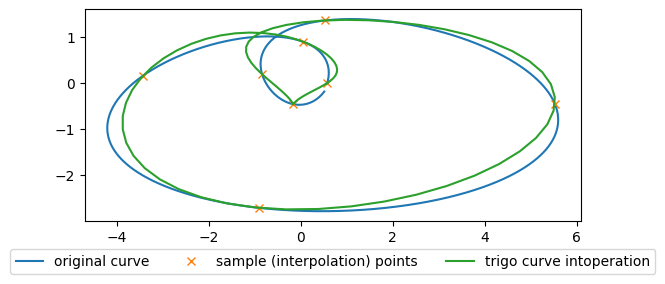

In [25]:
# trigo inteporlation

S = 8
sample_u = np.linspace(0,1,S,endpoint=False)

data_points = np.zeros((S,2), dtype=np.float64)
for i_,u_ in enumerate(sample_u):
    data_points[i_,:] = [x_func(u_),y_func(u_)]

y = np.fft.fft(data_points,axis=0,norm="ortho")

def func(u):
    s = 0
    for k in range(1,int(S/2)):
        s += y[k].view("(2,)float") @ np.array([np.cos(2*np.pi*u*k), -np.sin(2*np.pi*u*k)])
    return ( y[0].real + 2*s + y[int(S/2)].real*np.cos(2*np.pi*u*(S/2)) )/np.sqrt(S)

plot_n = 100
plot_curve = np.zeros((plot_n,2))
for i, u in enumerate(np.linspace(0,1,plot_n)):
    plot_curve[i] = func(u)

fig, ax = plt.subplots()
ax.plot(xs, ys, label="original curve")
ax.plot(data_points[:,0], data_points[:,1], "x", label="sample (interpolation) points")
ax.plot(plot_curve[:,0],plot_curve[:,1], label="trigo curve intoperation")
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'plots/trigo.eps', format='eps', bbox_inches='tight')
plt.show()

0.16628031733109913
0.16562249425672754


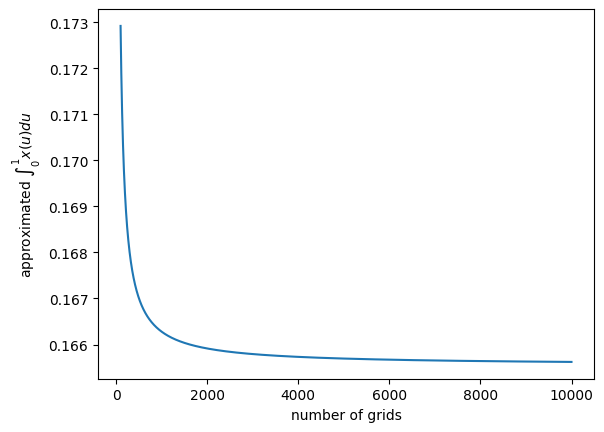

In [57]:


def find_integral(n_grid):
    us = np.linspace(0,1,n_grid)
    xs = [x_func(u_) for u_ in us]
    du = 1/(3*n_grid) * (
        xs[0] + xs[-1] \
            + 4*sum([ xs[2*i-1] for i in range(int(n_grid/2))]) \
            + 2*sum([ xs[2*i] for i in range(int(n_grid/2))])
        )
    return du
ngrids = np.arange(50,5000) * 2
print(find_integral(1000))
areas = [find_integral(ng) for ng in ngrids]
print(areas[-1])
fig, ax = plt.subplots()
ax.plot(ngrids, areas, label="integration")
# leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
# ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("number of grids")
ax.set_ylabel(r"approximated $\int_0^1 x(u) d u$")
plt.savefig(f'plots/integration.eps', format='eps', bbox_inches='tight')
plt.show()